<a href="https://colab.research.google.com/github/shivendra3singh/Churn-Prediction/blob/master/bert4rec_with_genres_embed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT4REC with genres embed

In [100]:
!git clone https://github.com/jaywonchung/BERT4Rec-VAE-Pytorch.git

Cloning into 'BERT4Rec-VAE-Pytorch'...
remote: Enumerating objects: 172, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 172 (delta 55), reused 48 (delta 47), pack-reused 77 (from 1)
Receiving objects: 100% (172/172), 3.05 MiB | 24.58 MiB/s, done.
Resolving deltas: 100% (65/65), done.


In [102]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=d0f80ac85532a26218988c1e49eaa89fe15b123dc48f8ab8d0ec216235c81d32
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [109]:
!python /content/BERT4Rec-VAE-Pytorch/main.py --template train_bert

2024-12-27 15:27:25.497525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-27 15:27:25.534358: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-27 15:27:25.544799: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-27 15:27:25.562372: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-27 15:27:27.116907: W tensorflow/compiler/tf2

In [112]:
pd.read_pickle('/content/Data/preprocessed/ml-1m_min_rating0-min_uc5-min_sc0-splitleave_one_out/random-sample_size0-seed0.pkl')

{0: [],
 1: [],
 2: [],
 3: [],
 4: [],
 5: [],
 6: [],
 7: [],
 8: [],
 9: [],
 10: [],
 11: [],
 12: [],
 13: [],
 14: [],
 15: [],
 16: [],
 17: [],
 18: [],
 19: [],
 20: [],
 21: [],
 22: [],
 23: [],
 24: [],
 25: [],
 26: [],
 27: [],
 28: [],
 29: [],
 30: [],
 31: [],
 32: [],
 33: [],
 34: [],
 35: [],
 36: [],
 37: [],
 38: [],
 39: [],
 40: [],
 41: [],
 42: [],
 43: [],
 44: [],
 45: [],
 46: [],
 47: [],
 48: [],
 49: [],
 50: [],
 51: [],
 52: [],
 53: [],
 54: [],
 55: [],
 56: [],
 57: [],
 58: [],
 59: [],
 60: [],
 61: [],
 62: [],
 63: [],
 64: [],
 65: [],
 66: [],
 67: [],
 68: [],
 69: [],
 70: [],
 71: [],
 72: [],
 73: [],
 74: [],
 75: [],
 76: [],
 77: [],
 78: [],
 79: [],
 80: [],
 81: [],
 82: [],
 83: [],
 84: [],
 85: [],
 86: [],
 87: [],
 88: [],
 89: [],
 90: [],
 91: [],
 92: [],
 93: [],
 94: [],
 95: [],
 96: [],
 97: [],
 98: [],
 99: [],
 100: [],
 101: [],
 102: [],
 103: [],
 104: [],
 105: [],
 106: [],
 107: [],
 108: [],
 109: [],
 110: [],


### Import Libs

In [39]:
import math
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import warnings

### Make config

In [40]:
config = {
    'data_path' : '/content/sample_data/new/',
    'max_len' : 80,
    'hidden_units' : 256, # Embedding
    'num_heads' : 2, # Multi-head layer
    'num_layers': 2, # block encoder layer
    'dropout_rate' : 0.1, # dropout
    'lr' : 0.001,
    'batch_size' : 256,
    'num_epochs' : 10,
    'num_workers' : 2,
    'mask_prob' : 0.15,
}

In [41]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


### Work with Data

Опишем класс, который переделает исходный датасет, в последовательности просмотров фильмов

In [66]:
class MakeSequenceDataSet():
    """
    SequenceData

    Переделывет исходную таблицу (юзер: просмотренный фильм) в таблицу (юзер: последовательность просмотренных фильмов)
    """
    def __init__(self, data_path):

        print('Reading data...')
        self.df = pd.read_csv(os.path.join(data_path, 'ratings.dat'),sep='::', header=None,encoding='latin-1')
        self.df.columns = ['uid', 'movieId', 'rating', 'timestamp']
        self.movies = pd.read_csv(os.path.join(data_path, 'movies.dat'), sep='::', header=None,encoding='latin-1')
        self.movies.columns=['movieId', 'title', 'genres']
        print(self.df)
        print(self.movies)

        print('Applying genres...')

        self.genres = [
            "Action",
            "Adventure",
            "Animation",
            "Children's",
            "Comedy",
            "Crime",
            "Documentary",
            "Drama",
            "Fantasy",
            "Film-Noir",
            "Horror",
            "Musical",
            "Mystery",
            "Romance",
            "Sci-Fi",
            "Thriller",
            "War",
            "Western",
        ]

        for genre in self.genres:
            self.movies[genre] = self.movies["genres"].apply(
                lambda values: int(genre in values.split("|"))
            )

        self._movie_genres = self.movies[self.genres].to_numpy()

        print('Generate encoder and decoder...')
        self.item_encoder, self.item_decoder = self.generate_encoder_decoder(self.movies['movieId'])
        self.user_encoder, self.user_decoder = self.generate_encoder_decoder(self.df['uid'])
        self.num_item, self.num_user = len(self.item_encoder), len(self.user_encoder)

        self.df['item_idx'] = self.df['movieId'].apply(lambda x : self.item_encoder[x] + 1)
        self.df['user_idx'] = self.df['uid'].apply(lambda x : self.user_encoder[x])

        self.df = self.df.sort_values(['user_idx', 'timestamp'])

        print('Generate sequence data...')
        self.user_train, self.genres_seq, self.user_valid = self.generate_sequence_data()

        print('Finish!!!')

    def generate_encoder_decoder(self, col) -> dict:
        """
        encoder, decoder

        Args:
            col (str): columns
        Returns:
            dict: encoder, decoder
        """

        encoder = {}
        decoder = {}
        ids = col.unique()
        print(ids)
        for idx, _id in enumerate(ids):
            print(idx,_id)
            encoder[_id] = idx
            decoder[idx] = _id

        return encoder, decoder

    def movie_genres(self, idx):
        return self._movie_genres[idx-1].tolist()


    def generate_sequence_data(self) -> dict:
        """
        sequence_data

        Returns:
            dict: train user sequence / valid user sequence
        """
        users = defaultdict(list)
        user_train = {}
        genres_seq = {}
        user_valid = {}
        group_df = self.df.groupby('user_idx')
        for user, item in group_df:
            users[user].extend(item['item_idx'].tolist())


        for user in users:
            user_train[user] = users[user][:-1]
            genres_seq[user] = [self.movie_genres(i) for i in user_train[user]]
            user_valid[user] = users[user][-1]

        return user_train, genres_seq, user_valid

    def get_train_valid_data(self):
        return self.user_train, self.genres_seq, self.user_valid

Дальше опишем класс Dataset для обучения. Сам датасет будет состоять из пользователей, и последовательностей их просмотров. При этом при обучении модели, подаваемая последовательность модифицируется следующим образом:
- Выбирается 15% случайных токенов из последоваетельности
- Из выбранных токенов:
    - 80% заменяется токеном маски
    - 10% заменяется случайным токеном
    - 10% остаются без изменений

В дополнении к последовательности просмотренных фильмов, есть последовательность жанров к просмотренным фильмам, которая модифицируется тем же способом, что и последовательность фильмов.

Таким образом, один элемент из обучающей выборки выглядит следующим образом:

```python
Dataset[i] = item_sequence, genres_sequence, labels
```
`item_sequenceitem_sequence` - измененная последовательность фильмов [1 x n] (n - длина последовательности)

`genres_sequencegenres_sequence` - измененная последовательность жанров к фильмам [m x n] (m - число жанров, нашем случае m = 18)

`labels` - истинная последовательность просмотренных фильмов, т.е. то что должна вернуть модель [1 x n]
    

In [67]:
class BERTRecDataSet(Dataset):
    def __init__(self, user_train, movie_genres, max_len, num_user, num_item, mask_prob):
        self.user_train = user_train
        self.movie_genres = movie_genres
        self.max_len = max_len
        self.num_user = num_user
        self.num_item = num_item
        self.mask_prob = mask_prob
        self._all_items = set([i for i in range(1, self.num_item + 1)])

    def __len__(self):
        return self.num_user

    def __getitem__(self, user):

        user_seq = self.user_train[user]
        genre_seq = self.movie_genres[user]
        tokens = []
        genres_seq = []
        labels = []

        for s, g in zip(user_seq[-self.max_len:], genre_seq[-self.max_len:]):
            prob = np.random.random()
            if prob < self.mask_prob:
                prob /= self.mask_prob
                if prob < 0.8:
                    # masking
                    tokens.append(self.num_item + 1) # (index, genres)  mask_index: num_item + 1, 0: pad, 1~num_item: item index
                    genres_seq.append([1]*18)
                elif prob < 0.9:
                    # noise
                    rnd_token = self.random_neg_sampling(rated_item = user_seq, num_item_sample = 1)[0] # item random sampling
                    tokens.append(rnd_token)
                    genres_seq.append([random.randint(0, 1) for _ in range(18)])
#                   genres_seq.append(self.movie_genres(rnd_token))
                else:
                    tokens.append(s)
                    genres_seq.append(g)
            else:
                tokens.append(s)
                genres_seq.append(g)
            labels.append(s)

        mask_len = self.max_len - len(tokens)

        tokens = [0] * mask_len + tokens
        genres_seq = [[0]*18] * mask_len + genres_seq
        labels = [0] * mask_len + labels

        return torch.LongTensor(tokens), torch.Tensor(genres_seq), torch.LongTensor(labels)

    def random_neg_sampling(self, rated_item : list, num_item_sample : int):
        nge_samples = random.sample(range(1, self.num_item + 1), num_item_sample)
        return nge_samples

In [68]:
make_sequence_dataset = MakeSequenceDataSet(config['data_path'])

Reading data...


<ipython-input-66-c0ea4d49fb93>:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  self.df = pd.read_csv(os.path.join(data_path, 'ratings.dat'),sep='::', header=None,encoding='latin-1')
<ipython-input-66-c0ea4d49fb93>:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  self.movies = pd.read_csv(os.path.join(data_path, 'movies.dat'), sep='::', header=None,encoding='latin-1')


Streaming output truncated to the last 5000 lines.
1042 1043
1043 1044
1044 1045
1045 1046
1046 1047
1047 1048
1048 1049
1049 1050
1050 1051
1051 1052
1052 1053
1053 1054
1054 1055
1055 1056
1056 1057
1057 1058
1058 1059
1059 1060
1060 1061
1061 1062
1062 1063
1063 1064
1064 1065
1065 1066
1066 1067
1067 1068
1068 1069
1069 1070
1070 1071
1071 1072
1072 1073
1073 1074
1074 1075
1075 1076
1076 1077
1077 1078
1078 1079
1079 1080
1080 1081
1081 1082
1082 1083
1083 1084
1084 1085
1085 1086
1086 1087
1087 1088
1088 1089
1089 1090
1090 1091
1091 1092
1092 1093
1093 1094
1094 1095
1095 1096
1096 1097
1097 1098
1098 1099
1099 1100
1100 1101
1101 1102
1102 1103
1103 1104
1104 1105
1105 1106
1106 1107
1107 1108
1108 1109
1109 1110
1110 1111
1111 1112
1112 1113
1113 1114
1114 1115
1115 1116
1116 1117
1117 1118
1118 1119
1119 1120
1120 1121
1121 1122
1122 1123
1123 1124
1124 1125
1125 1126
1126 1127
1127 1128
1128 1129
1129 1130
1130 1131
1131 1132
1132 1133
1133 1134
1134 1135
1135 1136
1136 1137

In [69]:
user_train, movie_genres, user_valid = make_sequence_dataset.get_train_valid_data()

In [99]:
user_valid

{0: 48,
 1: 1849,
 2: 2013,
 3: 1886,
 4: 286,
 5: 594,
 6: 3039,
 7: 3189,
 8: 2226,
 9: 2184,
 10: 3114,
 11: 3294,
 12: 2754,
 13: 1208,
 14: 3442,
 15: 2633,
 16: 699,
 17: 1638,
 18: 1216,
 19: 1351,
 20: 2732,
 21: 899,
 22: 2575,
 23: 2589,
 24: 3730,
 25: 2615,
 26: 1187,
 27: 2064,
 28: 2482,
 29: 3486,
 30: 1456,
 31: 3218,
 32: 2678,
 33: 3189,
 34: 1147,
 35: 3571,
 36: 1073,
 37: 294,
 38: 86,
 39: 2749,
 40: 1598,
 41: 2303,
 42: 2790,
 43: 2229,
 44: 352,
 45: 3212,
 46: 34,
 47: 2983,
 48: 2243,
 49: 1506,
 50: 1827,
 51: 2638,
 52: 578,
 53: 3439,
 54: 353,
 55: 511,
 56: 1223,
 57: 66,
 58: 1225,
 59: 2515,
 60: 3839,
 61: 2871,
 62: 538,
 63: 2937,
 64: 942,
 65: 1893,
 66: 891,
 67: 2729,
 68: 473,
 69: 3725,
 70: 2891,
 71: 3350,
 72: 3528,
 73: 2515,
 74: 2693,
 75: 3445,
 76: 2839,
 77: 700,
 78: 2058,
 79: 587,
 80: 258,
 81: 471,
 82: 2094,
 83: 1374,
 84: 3249,
 85: 54,
 86: 1198,
 87: 2905,
 88: 3672,
 89: 1406,
 90: 909,
 91: 1518,
 92: 3842,
 93: 3768,
 94:

In [73]:
bert4rec_dataset = BERTRecDataSet(
    user_train = user_train,
    movie_genres = movie_genres,
    max_len = config['max_len'],
    num_user = make_sequence_dataset.num_user,
    num_item = make_sequence_dataset.num_item,
    mask_prob = config['mask_prob'],
)

In [74]:
data_loader = DataLoader(
    bert4rec_dataset,
    batch_size = config['batch_size'],
    shuffle = True,
    pin_memory = True,
    num_workers = 4# config['num_workers'],
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [75]:
%%time
d = next(iter(data_loader))

CPU times: user 36.6 ms, sys: 123 ms, total: 160 ms
Wall time: 1.02 s


## Model

In [76]:
class PositionalEmbedding(nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()

        # Compute the positional encodings once in log space.
        self.pe = nn.Embedding(max_len, d_model)

    def forward(self, x):
        batch_size = x.size(0)
        return self.pe.weight.unsqueeze(0).repeat(batch_size, 1, 1)

class TokenEmbedding(nn.Embedding):
    def __init__(self, vocab_size, embed_size=512):
        super().__init__(vocab_size, embed_size, padding_idx=0)

class GenresEmbedding(nn.Module):
    def __init__(self, genres_size, embed_size=512):
        super().__init__()
        self.linear_1 = nn.Linear(genres_size, genres_size*2)
        self.act = nn.ReLU()
        self.linear_2 = nn.Linear(genres_size*2, embed_size)
    def forward(self, genres_vec):
        x = self.linear_2(self.act(self.linear_1(genres_vec)))
        return x

In [77]:
class BERTEmbedding(nn.Module):
    """
    BERT Embedding which is consisted with under features
        1. TokenEmbedding : normal embedding matrix
        2. PositionalEmbedding : adding positional information using sin, cos
        2. SegmentEmbedding : adding sentence segment info, (sent_A:1, sent_B:2)

        sum of all these features are output of BERTEmbedding
    """

    def __init__(self, vocab_size, genres_size, embed_size, max_len, dropout=0.1):
        """
        :param vocab_size: total vocab size
        :param embed_size: embedding size of token embedding
        :param dropout: dropout rate
        """
        super().__init__()
        self.token = TokenEmbedding(vocab_size=vocab_size, embed_size=embed_size)
        self.position = PositionalEmbedding(max_len=max_len, d_model=embed_size)
        self.genres_emb = GenresEmbedding(genres_size=genres_size, embed_size=embed_size)
        # self.segment = SegmentEmbedding(embed_size=self.token.embedding_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.embed_size = embed_size

    def forward(self, sequence, genres):
        x = self.token(sequence) + self.position(sequence) + self.genres_emb(genres)
        return self.dropout(x)

In [78]:
class Attention(nn.Module):
    """
    Compute 'Scaled Dot Product Attention
    """

    def forward(self, query, key, value, mask=None, dropout=None):
        scores = torch.matmul(query, key.transpose(-2, -1)) \
                 / math.sqrt(query.size(-1))

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        p_attn = F.softmax(scores, dim=-1)

        if dropout is not None:
            p_attn = dropout(p_attn)

        return torch.matmul(p_attn, value), p_attn

In [79]:
class MultiHeadedAttention(nn.Module):
    """
    Take in model size and number of heads.
    """

    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0

        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h

        self.linear_layers = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(3)])
        self.output_linear = nn.Linear(d_model, d_model)
        self.attention = Attention()

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [l(x).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linear_layers, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch.
        x, attn = self.attention(query, key, value, mask=mask, dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.d_k)

        return self.output_linear(x)

In [80]:
class GELU(nn.Module):
    """
    Paper Section 3.4, last paragraph notice that BERT used the GELU instead of RELU
    """

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

In [81]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()

    def forward(self, x):
        return self.w_2(self.dropout(self.activation(self.w_1(x))))

In [82]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [83]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

In [84]:
class TransformerBlock(nn.Module):
    """
    Bidirectional Encoder = Transformer (self-attention)
    Transformer = MultiHead_Attention + Feed_Forward with sublayer connection
    """

    def __init__(self, hidden, attn_heads, feed_forward_hidden, dropout):
        """
        :param hidden: hidden size of transformer
        :param attn_heads: head sizes of multi-head attention
        :param feed_forward_hidden: feed_forward_hidden, usually 4*hidden_size
        :param dropout: dropout rate
        """

        super().__init__()
        self.attention = MultiHeadedAttention(h=attn_heads, d_model=hidden, dropout=dropout)
        self.feed_forward = PositionwiseFeedForward(d_model=hidden, d_ff=feed_forward_hidden, dropout=dropout)
        self.input_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.output_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, mask):
        x = self.input_sublayer(x, lambda _x: self.attention.forward(_x, _x, _x, mask=mask))
        x = self.output_sublayer(x, self.feed_forward)
        return self.dropout(x)

In [85]:
class BERT(nn.Module):
    def __init__(self, bert_max_len, num_items, genres_size, bert_num_blocks, bert_num_heads,
                 bert_hidden_units, bert_dropout):
        super().__init__()

        # fix_random_seed_as(args.model_init_seed)
        # self.init_weights()

        max_len = bert_max_len
        num_items = num_items
        n_layers = bert_num_blocks
        heads = bert_num_heads
        self.vocab_size = num_items + 2
        self.genres_size = genres_size
        hidden = bert_hidden_units
        self.hidden = hidden
        dropout = bert_dropout

        # embedding for BERT, sum of positional, segment, token embeddings
        self.embedding = BERTEmbedding(vocab_size=self.vocab_size, genres_size=self.genres_size,
                                       embed_size=self.hidden, max_len=max_len, dropout=dropout)

        # multi-layers transformer blocks, deep network
        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(hidden, heads, hidden * 4, dropout) for _ in range(n_layers)])
        self.out = nn.Linear(hidden, num_items + 1)

    def forward(self, x, genres):
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)

        # embedding the indexed sequence to sequence of vectors
#         print(x.shape)
        x = self.embedding(x, genres)

        # running over multiple transformer blocks
        for transformer in self.transformer_blocks:
            x = transformer.forward(x, mask)

        x = self.out(x)
        return x

    def init_weights(self):
        pass

Принцип работы модели:
1) На вход модели дается последовательность просмотренных пользователем фильмов, а также последовательность жанров к просмотренным фильмам. Выходом модели является последовательность логитов просмотренных фильмов.

2) При обучении модели, мы учим ее предсказывать всю последовательность, так чтобы она умела отличать замаскированные токены, и выдавала вместо них верные токены.

3) При использовании модели к последовательности просмотренных фильмов в конце добавляется токен маски, и модель выдает последовательность. Последний элемент в этой последовательности и будет фильмом, который мы рекомендуем.

Пример входных данных:

In [86]:
d

[tensor([[   0,    0,    0,  ...,  477,  454, 1673],
         [ 258, 2481,  538,  ..., 3316, 2919, 1581],
         [   0,    0,    0,  ..., 2848, 1074, 1569],
         ...,
         [1595, 1196, 3884,  ..., 2850, 3884, 1629],
         [   0,    0,    0,  ..., 3684, 3413, 3254],
         [1082, 3884,  699,  ..., 2751,  590, 2694]]),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [1., 1., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 1., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[1., 1., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [1., 0., 0.,  ..., 0., 0., 0.],
          [0., 1., 1.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],


Пример выходных данных:

In [97]:
seq, genres, _ = d
output = model(seq.to(device), genres.to(device))
print(output)
print(output.shape)

tensor([[[ 0.0395,  2.5108, -3.7401,  ..., -1.9585,  0.8889,  0.3120],
         [ 0.4395,  4.4706, -5.0852,  ..., -0.5687, -2.3786,  1.4703],
         [-0.8501,  5.0798, -2.6504,  ..., -3.1287, -1.2018, -1.4289],
         ...,
         [-4.8098,  5.7805, -0.4008,  ..., -1.1463, -2.0800,  1.5772],
         [-4.4917,  1.2924, -5.5154,  ..., -0.4873, -5.1761, -0.4496],
         [-2.6392,  3.5554,  2.1326,  ..., -1.8906,  3.5459,  0.9565]],

        [[-2.6994, -0.6970,  5.7733,  ..., -3.6926, -0.5437, -4.7740],
         [-2.2634, -0.9479,  1.6502,  ..., -0.1050, -2.4086,  1.1165],
         [-1.4048,  0.1532,  1.0167,  ..., -8.8564, -1.2847, -5.1358],
         ...,
         [-0.9414,  0.1404,  2.1197,  ..., -3.7995,  4.5746, -6.4690],
         [-3.2092,  0.2510,  1.1832,  ..., -1.4777, -3.7169, -3.5472],
         [ 0.2278, -0.9714, -0.1218,  ...,  3.7521,  0.9359, -1.8437]],

        [[ 2.0944, -3.2513, -6.0267,  ...,  1.0984,  0.3500,  1.1376],
         [ 2.3312,  0.7409, -5.8003,  ...,  1

In [88]:
from IPython.display import clear_output
from tqdm import tqdm, trange

In [89]:
device

'cpu'

In [90]:
def train(model, criterion, optimizer, data_loader):
    model.train()
    loss_val = 0
    i = len(metrics['train_loss'])
    #, 'dev_ndcg': [] }
    for seq, genres, labels in data_loader:
        seq, genres, labels = seq.to(device), genres.to(device), labels.to(device)
        logits = model(seq, genres) # (bs, t, vocab)
        logits = logits.view(-1, logits.size(-1)) # (bs * t, vocab)
        labels = labels.view(-1) # (bs * t)

        optimizer.zero_grad()
        loss = criterion(logits, labels)

        loss_val += loss.item()
        metrics['train_loss'].append((i, loss.item()))

        loss.backward()
        optimizer.step()


        if i%100 == 0:
#             metrics['dev_ndcg'].append((i, compute_ndcg(model, dev_inp, dev_out)))
            clear_output(True)
            plt.figure(figsize=(5,4))
            for j, (name, history) in enumerate(sorted(metrics.items())):
#                 plt.subplot(1, len(metrics), j + 1)
                plt.title(name)
                plt.plot(*zip(*history))
                plt.grid()
            plt.show()
        i += 1

    loss_val /= len(data_loader)

    return loss_val

def evaluate(model, user_train, user_valid, max_len, data_loader, bert4rec_dataset, make_sequence_dataset):
    model.eval()

    NDCG = 0.0 # NDCG@10
    HIT = 0.0 # HIT@10

    num_item_sample = 100

    users = [user for user in range(make_sequence_dataset.num_user)]

    for user in tqdm(users):
        seq = (user_train[user] + [make_sequence_dataset.num_item + 1])[-max_len:] # mask last token
        genre_seq = ([make_sequence_dataset.movie_genres(i) for i in user_train[user]] + [[1]*18])[-max_len:]
        padding_len = max_len - len(seq)
#         print(genre_seq)
        seq = [0] * padding_len + seq
        genre_seq = [[0]*18] * padding_len + genre_seq

        rated = user_train[user] + [user_valid[user]]
        items = [user_valid[user]] + bert4rec_dataset.random_neg_sampling(rated_item = rated, num_item_sample = num_item_sample)

        with torch.no_grad():
            genre_seq = torch.Tensor([genre_seq]).to(device)
            seq = torch.LongTensor([seq]).to(device)

            predictions = -model(seq, genre_seq)
#             print(predictions.shape)
            predictions = predictions[0][-1][items] # sampling
#             print(predictions.shape)
            rank = predictions.argsort().argsort()[0].item() # label

        if rank < 10: #Top10
            NDCG += 1 / np.log2(rank + 2)
            HIT += 1

    NDCG /= len(users)
    HIT /= len(users)

    return NDCG, HIT


In [91]:
model = BERT(
    num_items = make_sequence_dataset.num_item,
    genres_size = 18,
    bert_hidden_units = config['hidden_units'],
    bert_num_heads = config['num_heads'],
    bert_num_blocks = config['num_layers'],
    bert_max_len = config['max_len'],
    bert_dropout = config['dropout_rate'],
).to(device)
metrics = {'train_loss': []}

In [92]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])

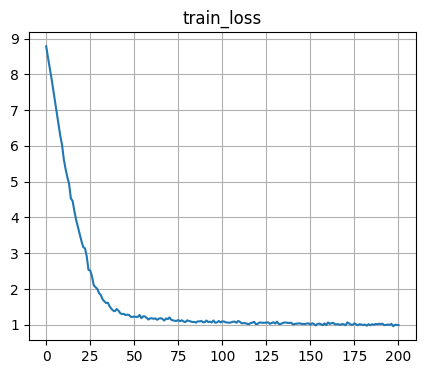

 90%|█████████ | 9/10 [39:00<04:19, 259.56s/it]

Epoch:   9| Train loss: 0.99287


100%|██████████| 10/10 [43:18<00:00, 259.81s/it]

Epoch:  10| Train loss: 0.97893


In [93]:
loss_list = []
ndcg_list = []
hit_list = []
for epoch in tqdm(range(1, config['num_epochs'] + 1)):
    train_loss = train(
        model = model,
        criterion = criterion,
        optimizer = optimizer,
        data_loader = data_loader)
    loss_list.append(train_loss)

    print(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}')

In [ ]:
torch.save(model.state_dict(), os.path.join('/kaggle/working', 'weights_1.pth'))

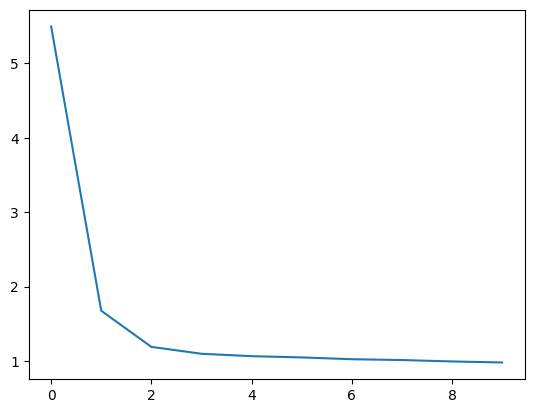

In [94]:
plt.plot(loss_list)

In [ ]:
model.load_state_dict(torch.load(os.path.join('/kaggle/working', 'weights_1.pth')))
model.eval()

BERT(
  (embedding): BERTEmbedding(
    (token): TokenEmbedding(27280, 256, padding_idx=0)
    (position): PositionalEmbedding(
      (pe): Embedding(80, 256)
    )
    (genres_emb): GenresEmbedding(
      (linear_1): Linear(in_features=18, out_features=36, bias=True)
      (act): ReLU()
      (linear_2): Linear(in_features=36, out_features=256, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (attention): MultiHeadedAttention(
        (linear_layers): ModuleList(
          (0-2): 3 x Linear(in_features=256, out_features=256, bias=True)
        )
        (output_linear): Linear(in_features=256, out_features=256, bias=True)
        (attention): Attention()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): PositionwiseFeedForward(
        (w_1): Linear(in_features=256, out_features=1024, bias=True)
        (w_2): Linear(in_features=1024, out_features=256, bias=True)
  

In [95]:
ndcg, hit = evaluate(
    model = model,
    user_train = user_train,
    user_valid = user_valid,
    max_len = config['max_len'],
    data_loader = None,
    make_sequence_dataset = make_sequence_dataset,
    bert4rec_dataset = bert4rec_dataset
)

100%|██████████| 6040/6040 [01:46<00:00, 56.96it/s]


In [96]:
print(f'NDCG@10: {ndcg}| HIT@10: {hit}')

NDCG@10: 0.29512679451381035| HIT@10: 0.5392384105960265
